# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


# DATA COLLECTION

In [2]:
sp500_data = conn.raw_sql("""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '1990-01-01'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [3]:
risk_free_data = conn.raw_sql('''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '1990-01-01'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8748,2024-09-24,0.00020
8749,2024-09-25,0.00020
8750,2024-09-26,0.00020
8751,2024-09-27,0.00020


### COMPANY DATA

In [4]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available

comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')

In [5]:
company_search = 'APPLE' # FIND A COMPANY HERE

comps[comps['company_name'].str.contains(f'{company_search}')]

,permno,company_name
555,86806,APPLERA CORP
1247,83355,APPLEWOODS INC
2773,78717,APPLEBEES INTERNATIONAL INC
7792,92618,DR PEPPER SNAPPLE GROUP INC
11331,14593,APPLE COMPUTER INC
11423,44679,BIG APPLE SUPERMARKETS INC
12087,85551,APPLE BANCORP INC
13048,84771,APPLE ORTHODONTIX INC
13359,15338,APPLE HOSPITALITY REIT INC
15691,78203,SNAPPLE BEVERAGE CORP


In [6]:
company_name = 'APPLE COMPUTER INC' # root variable for rest of notebook

comp0 = comps[comps['company_name'] == f'{company_name}']

company_permno = str(comp0['permno'][comp0.index[0]])

comp0

,permno,company_name
11331,14593,APPLE COMPUTER INC


In [7]:
link = conn.raw_sql(f'''
SELECT *
FROM crsp.ccmxpf_linktable
WHERE lpermno = {company_permno};
''')

company_gvkey = link['gvkey'][0]

link

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,001690,P,01,LU,14593.0,7.0,1.0,1980-12-12,None


In [8]:
company_fin_data = conn.raw_sql(f'''
SELECT
    datadate AS date,
    atq AS total_assets,  -- Total Assets
    chq AS cash_holdings,  -- Cash and Short-Term Investments
    rdq AS reporting_date -- Date of which information was reported
FROM
    comp.fundq
WHERE
    gvkey = '{company_gvkey}'
    AND datadate >= '1990-01-01'  -- Ensure data is after the link start date
''')

company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])

start_date = company_fin_data['date'].min()
end_date = company_fin_data['date'].max()
all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
full_range_df = pd.DataFrame({'date': all_months})

company_fin_data = pd.merge(full_range_df, company_fin_data, on='date', how='left')

company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
company_fin_data['month_end'] = company_fin_data['date']

company_fin_data

# company['date'] = company['reporting_date'] # backtest logic TODO



,date,total_assets,cash_holdings,reporting_date,month_start,month_end
0,1990-03-31,2775.670,NaN,1990-04-18,1990-03-01,1990-03-31
1,1990-04-30,NaN,NaN,NaT,1990-04-01,1990-04-30
2,1990-05-31,NaN,NaN,NaT,1990-05-01,1990-05-31
3,1990-06-30,2889.536,NaN,1990-07-18,1990-06-01,1990-06-30
4,1990-07-31,NaN,NaN,NaT,1990-07-01,1990-07-31
...,...,...,...,...,...,...
410,2024-05-31,NaN,NaN,NaT,2024-05-01,2024-05-31
411,2024-06-30,331612.000,25565.0,2024-08-01,2024-06-01,2024-06-30
412,2024-07-31,NaN,NaN,NaT,2024-07-01,2024-07-31
413,2024-08-31,NaN,NaN,NaT,2024-08-01,2024-08-31


#### FORWARD FILL

In [9]:
company_fin_data = company_fin_data.ffill().dropna()

In [10]:
company_stock_prcs = conn.raw_sql(f'''
SELECT
    date,
    prc AS stock_price,
    ret AS stock_return  -- Stock returns from CRSP
    -- prc * shrout AS market_cap  -- Market cap
FROM
    crsp.msf
WHERE
    permno = {company_permno}
''')

company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])

company_stock_prcs

,date,stock_price,stock_return
0,1980-11-28,NaN,NaN
1,1980-12-31,-34.18750,NaN
2,1981-01-30,-28.37500,-0.170018
3,1981-02-27,-26.62500,-0.061674
4,1981-03-31,-24.62500,-0.075117
...,...,...,...
513,2023-08-31,187.87000,-0.042454
514,2023-09-29,171.21001,-0.088678
515,2023-10-31,170.77000,-0.002570
516,2023-11-30,189.95000,0.113720


In [11]:
# Create new columns with just year and month
company_fin_data['year_month'] = company_fin_data['date'].dt.strftime('%Y-%m')
company_stock_prcs['year_month'] = company_stock_prcs['date'].dt.strftime('%Y-%m')

company = pd.merge(company_fin_data, company_stock_prcs, on='year_month')

company.drop(columns=['year_month', 'date_y'], axis=1, inplace=True)
company.rename(columns={'date_x':'date'}, inplace=True)

# company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='inner')

company

,date,total_assets,cash_holdings,reporting_date,month_start,month_end,stock_price,stock_return
0,2006-12-31,19461.0,7159.0,2007-01-17,2006-12-01,2006-12-31,84.84000,-0.074406
1,2007-01-31,19461.0,7159.0,2007-01-17,2007-01-01,2007-01-31,85.73000,0.010490
2,2007-02-28,19461.0,7159.0,2007-01-17,2007-02-01,2007-02-28,84.61000,-0.013064
3,2007-03-31,18711.0,7095.0,2007-04-25,2007-03-01,2007-03-31,92.91000,0.098097
4,2007-04-30,18711.0,7095.0,2007-04-25,2007-04-01,2007-04-30,99.80000,0.074158
...,...,...,...,...,...,...,...,...
200,2023-08-31,335038.0,28408.0,2023-08-03,2023-08-01,2023-08-31,187.87000,-0.042454
201,2023-09-30,352583.0,29965.0,2023-11-02,2023-09-01,2023-09-30,171.21001,-0.088678
202,2023-10-31,352583.0,29965.0,2023-11-02,2023-10-01,2023-10-31,170.77000,-0.002570
203,2023-11-30,352583.0,29965.0,2023-11-02,2023-11-01,2023-11-30,189.95000,0.113720


In [12]:
def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
    mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
    return agg_func(daily_data.loc[mask, column])

company['snp_return'] = company.apply(
    lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'daily_return', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

company['rf_rate'] = company.apply(
    lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

company.drop(columns=['month_start', 'month_end'], axis=1, inplace=True)

# CALCULATIONS (CASH-HEDGING & RETURNS)

In [13]:
company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])

### $ b_{t}^{i} $ - return on cash between periods

In [14]:
# the paper calculates it in a pretty complicated method, we'll start like this

company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
company['b_it'] = ( company['cash_holdings'] - company['cash_holdings_t_minus_1'] ) / company['cash_holdings_t_minus_1']

### $ e_{t}^{i} $ - cash hedged returns

In [15]:
# calculate the cash-hedged return (e_it)

company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

company

,date,total_assets,cash_holdings,reporting_date,stock_price,stock_return,snp_return,rf_rate,cash_share_weight,cash_holdings_t_minus_1,b_it,cash_hedged_return
0,2006-12-31,19461.0,7159.0,2007-01-17,84.84000,-0.074406,0.012615,0.004008,0.367864,NaN,NaN,NaN
1,2007-01-31,19461.0,7159.0,2007-01-17,85.73000,0.010490,0.014056,0.004409,0.367864,7159.0,0.000000,0.016595
2,2007-02-28,19461.0,7159.0,2007-01-17,84.61000,-0.013064,-0.021846,0.003807,0.367864,7159.0,0.000000,-0.020666
3,2007-03-31,18711.0,7095.0,2007-04-25,92.91000,0.098097,0.009981,0.004188,0.379189,7159.0,-0.008940,0.163475
4,2007-04-30,18711.0,7095.0,2007-04-25,99.80000,0.074158,0.043292,0.004409,0.379189,7095.0,0.000000,0.119453
...,...,...,...,...,...,...,...,...,...,...,...,...
200,2023-08-31,335038.0,28408.0,2023-08-03,187.87000,-0.042454,-0.017717,0.004610,0.084790,28408.0,0.000000,-0.046387
201,2023-09-30,352583.0,29965.0,2023-11-02,171.21001,-0.088678,-0.048720,0.004208,0.084987,28408.0,0.054809,-0.102005
202,2023-10-31,352583.0,29965.0,2023-11-02,170.77000,-0.002570,-0.021980,0.004630,0.084987,29965.0,0.000000,-0.002809
203,2023-11-30,352583.0,29965.0,2023-11-02,189.95000,0.113720,0.089178,0.004419,0.084987,29965.0,0.000000,0.124282


# BETA CALCULATION

Seems like in some instances cash_hedged_returns is getting super over inflated. Ideally, that is what we want! But will need to make sure the raise in risk is also reflected.

Next steps:
* Calculate Beta for non-cash assets in NVIDIA
* Use above data to test returns in cash-hedged for NVIDIA over time (long-only) 
* (etc)

Calculating Stock Beta and Cash-Hedged Beta (PiT).

In [16]:
window = 65 # months

def calculate_rolling_beta(stock_return, market_return, window):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

In [17]:

company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'], window)
company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'], window)
company['snp_beta'] = calculate_rolling_beta(company['snp_return'], company['snp_return'], window)

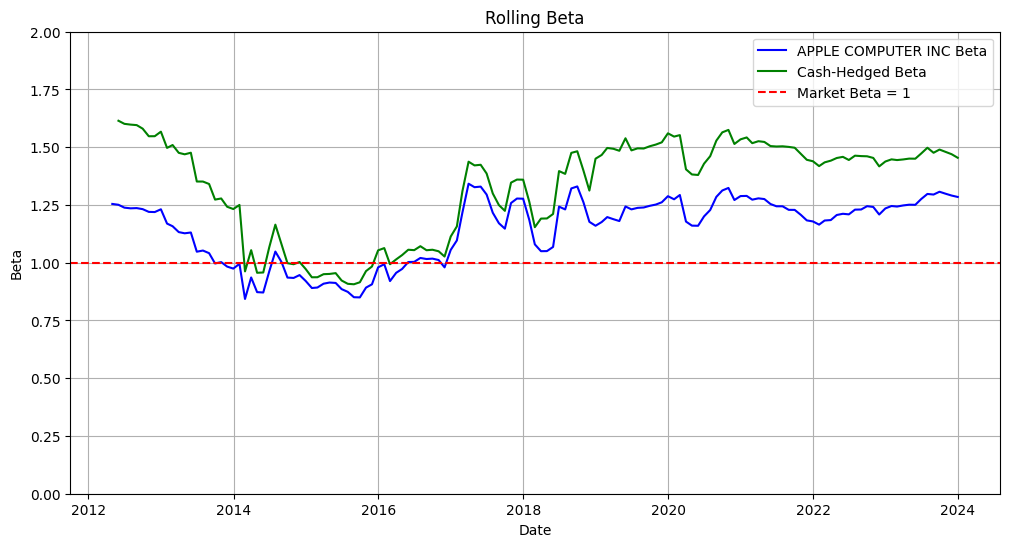

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['company_beta'], label=f'{company_name} Beta', color='blue')
plt.plot(company['date'], company['cash_hedged_beta'], label='Cash-Hedged Beta', color='green')
plt.axhline(1, color='red', linestyle='--', label='Market Beta = 1')
plt.title('Rolling Beta')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.ylim(-0, 2)
plt.grid()
plt.show()


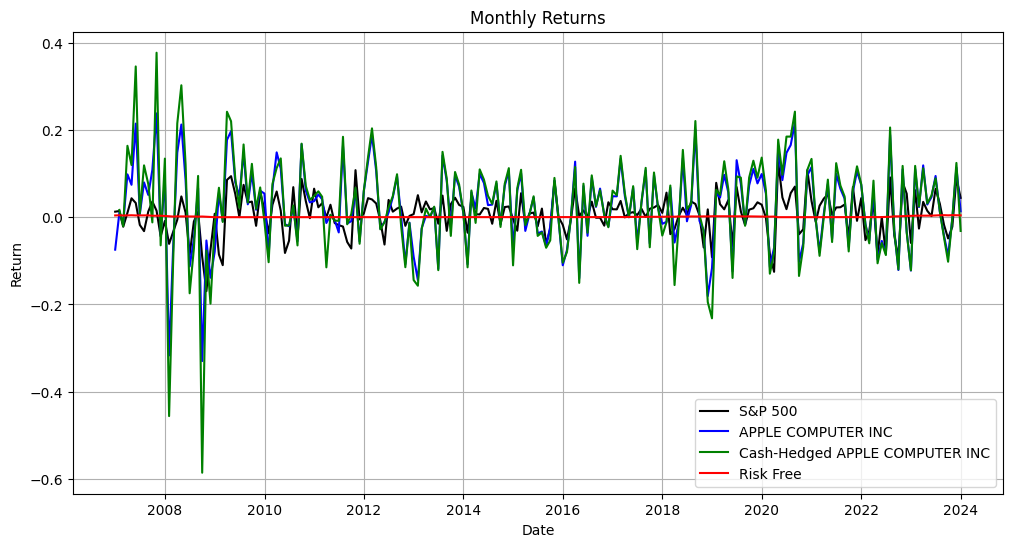

In [19]:

plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['snp_return'], label='S&P 500', color='black')
plt.plot(company['date'], company['stock_return'], label=f'{company_name}', color='blue')
plt.plot(company['date'], company['cash_hedged_return'], label=f'Cash-Hedged {company_name}', color='green')
plt.plot(company['date'], company['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [20]:
company['snp_cum_return'] = (1 + company['snp_return']).cumprod() - 1
company['company_cum_return'] = (1 + company['stock_return']).cumprod() - 1
company['cash_hedged_cum_return'] = (1 + company['cash_hedged_return']).cumprod() - 1
company['rf_cum_return'] = (1 + company['rf_rate']).cumprod() - 1

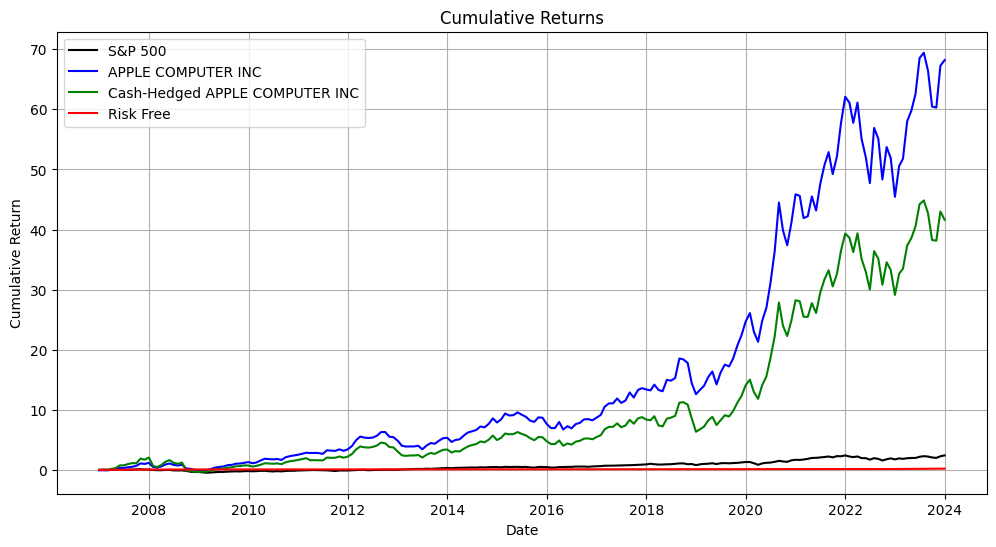

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['snp_cum_return'], label='S&P 500', color='black')
plt.plot(company['date'], company['company_cum_return'], label=f'{company_name}', color='blue')
plt.plot(company['date'], company['cash_hedged_cum_return'], label=f'Cash-Hedged {company_name}', color='green')
plt.plot(company['date'], company['rf_cum_return'], label='Risk Free', color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

In [23]:
def sharpe(ret):
    excess_ret = company[f"{ret}"] - company["rf_rate"]
    average_excess_return = excess_ret.mean()
    std_excess_return = excess_ret.std()
    return (average_excess_return / std_excess_return) * np.sqrt(12)

print(f"{company_name} Sharpe Ratio:", '{0:.4f}'.format(sharpe('stock_return')))
print(f"Cash Hedged {company_name} Sharpe Ratio:", '{0:.4f}'.format(sharpe('cash_hedged_return')))
print("SNP500 Sharpe Ratio:", '{0:.4f}'.format(sharpe('snp_return')))

APPLE COMPUTER INC Sharpe Ratio: 0.9335
Cash Hedged APPLE COMPUTER INC Sharpe Ratio: 0.7564
SNP500 Sharpe Ratio: 0.4648


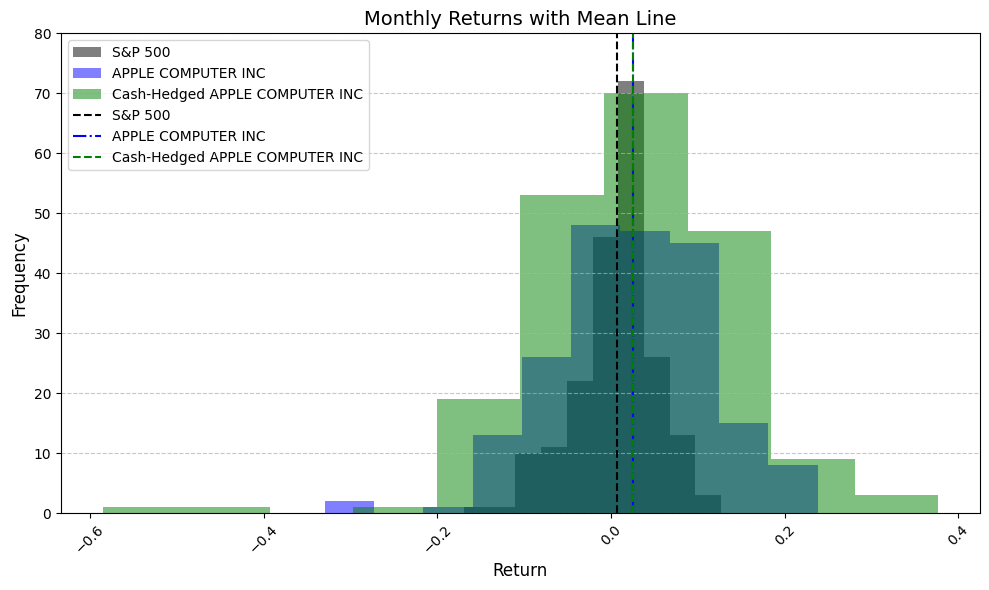

In [47]:
# Plot the bar graph
plt.figure(figsize=(10, 6))

plt.hist(company['snp_return'], label='S&P 500', color='black', alpha=0.5)
plt.hist(company['stock_return'], label=f'{company_name}', color='blue', alpha=0.5)
plt.hist(company['cash_hedged_return'], label=f'Cash-Hedged {company_name}', color='green', alpha=0.5)

# Add the mean line
plt.axvline(company["snp_return"].mean(), color="black", linestyle="--", label=f"S&P 500")
plt.axvline(company["stock_return"].mean(), color="blue", linestyle="-.", label=f'{company_name}')
plt.axvline(company["cash_hedged_return"].mean(), color="green", linestyle="--", label=f'Cash-Hedged {company_name}')

# Customize the plot
plt.title("Monthly Returns with Mean Line", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.ylim(0, 80)
plt.show()